In [162]:
import requests
import urllib
import pickle
import tqdm
from PIL import Image
import os
import numpy as np
from geopy.geocoders import GoogleV3, Nominatim
from geopy.distance import great_circle, vincenty
from IPython.display import Image, display
import random

In [4]:
def open_pkl(path):
    """Open pickle file."""
    with open(path, 'r') as picklefile:
        f = pickle.load(picklefile)
    return f

def to_pkl(path, name):
    "Pickle a file."
    with open(path, 'w') as picklefile:
        pickle.dump(name, picklefile)

In [29]:
def get_image(lat, lon):
    """Fetch google streetview image for given coordinate and save to disk."""
    url = 'http://maps.googleapis.com/maps/api/streetview?size=470x306&location=%f,%f&sensor=false' %(lat, lon)
    urllib.urlretrieve(url, 'streetview/%f,%f.jpg' %(lat, lon))
    Image('streetview/%f,%f.jpg' %(lat, lon))

In [122]:
def get_image_url(lat, lon):
    """Return google streetview image url given coordinate."""
    return 'http://maps.googleapis.com/maps/api/streetview?size=470x306&location=%f,%f&sensor=false.jpg' %(lat, lon)

### APP PIPELINE

#### Open pickled files

In [8]:
sfi = open_pkl('data/pickled/scores_for_impact_0327.pkl')
ssp = open_pkl('data/pickled/ss_withzip.pkl')

In [50]:
ssp.replace('no result', np.nan, inplace = True)
ssp.dropna(inplace = True)

#### 1. Get lat, lon coordinates given an address.

In [23]:
def get_coord_from_address(add, borough):
    geolocator = Nominatim()
    location = geolocator.geocode(add + ' ' + borough)
    return (location.latitude, location.longitude)

#### 2. Find closest coordinate within ssp dataset.

Split by borough.

In [93]:
boro_dict = {'bx': '005', 'bk': '047', 'mn': '061', 'qn': '081', 'si': '085' }

In [94]:
boro_dict_rev = dict(zip(boro_dict.values(), boro_dict.keys()))
ssp['boro'] = ssp.fips_tract.apply(lambda x: boro_dict_rev[x[2:5]] if x[2:5] in boro_dict_rev else np.nan)
ssp.dropna(inplace = True)

In [95]:
boro_storage = []
for b in boro_dict.keys():
    boro_storage.append(ssp[ssp.boro == b])

In [149]:
# create dictionary with keys = boroughs and values = list of coordinates in that borough
ssp_coords_boro = {}
for dfidx in range(len(boro_storage)):
    ssp_coords_boro[boro_dict.keys()[dfidx]] = zip(zip(boro_storage[dfidx].latitude, boro_storage[dfidx].longitude), boro_storage[dfidx].fips_tract)

In [103]:
# match potential borough inputs with actual borough keys
boro_match_dict = {'brooklyn': 'bk', 
                   'manhttan': 'mn', 
                   'new york': 'mn', 
                   'queens': 'qn', 
                   'staten island': 'si'}

In [12]:
ssp_coords = zip(ssp.latitude, ssp.longitude)

In [145]:
ssp_coords = zip(zip(ssp.latitude.values, ssp.longitude.values), ssp.fips_tract.values)

Functions.

In [150]:
def get_diff(zip_pair, point_pair):
    return sum((abs(zip_pair[0] - point_pair[0]), abs(zip_pair[1] - point_pair[1])))

def get_zip_diff(point, zip_list):
    distances = [(get_diff(point, p[0]), p[0]) for p[0] in coords_list]
    return min(distances)[1]

In [11]:
def get_distance(zip_pair, point_pair):
    """Get distance between two (lat, lon) pairs."""
    return vincenty(zip_pair, point_pair).miles

In [160]:
def get_shortest_distance(point, boro, coord_dict):
    """Get closet coordinate in dataset given a (lat, lon) pair. Based on distance."""
    # point = (lat, lon)
    try:
        if boro in coord_dict:
            coords_list = coord_dict[boro] # search in boro coord list
        else:
            coords_list = coord_dict[boro_match_dict[boro]] # match boro name, search in boro coord list
    except:
        coords_list = ssp_coords # if not found, use entire coord list 
    distances = [(get_diff(point, p[0]), p[0], p[1]) for p in coords_list]
    closest_coord = min(distances)[1]
    tract = min(distances)[2]
    return closest_coord, tract 

In [ ]:
get_shortest_distance()

#### 3. Show image of location and four (or X) images from random coordinates within the same census tract.

In [ ]:
def get_image_url(lat, lon):
    """Return google streetview image url given coordinate."""
    return 'http://maps.googleapis.com/maps/api/streetview?size=470x306&location=%f,%f&sensor=false.jpg' %(lat, lon)

In [135]:
ssp['coord'] = ssp.apply(lambda row: (row.latitude, row.longitude), axis = 1)

In [140]:
# create dict of coordinates for each census tract in order to find other points in that tract 
def coords_by_ct(df):
    d = {}
    grouped = df.groupby('fips_tract')
    for t, data in grouped:
        d[t] = [coord for coord in data.coord]
    return d

In [141]:
tract_coord_dict = coords_by_ct(ssp)

In [173]:
def get_random_five(tract, tract_coord_dict):
    """Choose five random points within the same census tract as a given point.
    Return list of five points and their google street view image urls."""
    coords = tract_coord_dict[tract]
    random_coords = random.sample(coords, 5)
    urls = [get_image_url(pt[0], pt[1]) for pt in random_coords]
    return random_coords, urls

#### 4. Show perceived safety zscore, actual danger zscore, and difference score. + other demographic data?

Clean up dfs with demographic data.

In [177]:
sfi_detailed = open_pkl('data/pickled/ssp_scores_tract_0327.pkl')

In [178]:
sfi_detailed.head()

,fips_tract,crime_rate_mean,crime_rate_median,crime_rate_std,danger_score_raw_mean,danger_score_raw_median,danger_score_raw_std,fips_tract_x,num_images,fips_tract_y,...,workers,total_pop,crime_rate_std_from_mean,danger_score_std_from_mean,crime_rate_mad_from_med,danger_score_mad_from_med,diff_std_from_mean,diff_mad_from_med,n_type,diff_zscore
fips_tract,,,,,,,,,,,,,,,,,,,,,
36005000200,36005000200,6.966225,7.184847,1.409556,13.380615,13.196584,3.535304,36005000200,248,36005000200,...,51,5146,-0.513564,0.030596,-0.689665,0.254569,-0.544159,-0.944234,similar_tp,-0.820954
36005000400,36005000400,7.218020,5.878031,3.466449,15.123690,14.882082,4.275268,36005000400,281,36005000400,...,310,5882,-0.483440,0.898981,-0.621122,1.721292,-1.382421,-2.342414,safer_tp,-1.854429
36005001600,36005001600,19.745863,26.351351,9.434868,14.666660,14.726530,4.053025,36005001600,236,36005001600,...,578,5990,1.015342,0.671292,2.789158,1.336720,0.344049,1.452437,similar_tp,0.950563
36005001900,36005001900,11.537322,9.397944,2.386701,19.048922,19.303408,4.479033,36005001900,423,36005001900,...,5666,8235,0.033304,2.854499,0.554661,5.024206,-2.821194,-4.469545,safer_tp,-3.426714
36005002000,36005002000,14.082878,13.456091,8.635744,13.067640,13.054655,3.878973,36005002000,169,36005002000,...,132,9091,0.337845,-0.125326,1.247602,-0.008786,0.463171,1.256388,similar_tp,0.805652


In [196]:
def clean_features(df):
    """Get df with socioeconomic and physical features (no crime scores).
    Use with sfi df. 
    """
    keep = ['fips_tract', 'median_hh_income', 'hh_type1_ht', 'median_rent',
                      'pct_hs_or_greater', 
                      'pct_male', 'median_age', 
                      'YearBuilt',
                      'race_pct_nonwhite', 
                      'hh_type_pct_nonfamily', 
                      'median_AssessTot', 'std_AssessTot', 
                      'median_NumFloors', 'std_NumFloors', 
                      'resident_density', 'worker_density', 
                      'unemp_rate', 
                      'num_311_complaints', 
                      'has_subway', 'pct_retail', 'pct_residential', 'pct_ind', 'pct_office', 'pct_other']
    return df[keep]

In [194]:
def clean_crime_scores(df):
    keep = ['fips_tract', 'crime_rate_median', 'danger_score_raw_median', 
            'danger_score_mad_from_med', 'crime_rate_mad_from_med', 
            'diff_mad_from_med', 'diff_zscore']
    return df[keep]

In [198]:
sfi_clean = clean_features(sfi)
sfi_detailed_clean = clean_crime_scores(sfi_detailed)

In [200]:
sfi_master = sfi_detailed_clean.merge(sfi_clean, left_on = 'fips_tract', right_on = 'fips_tract')

In [201]:
sfi_master.head()

,fips_tract,crime_rate_median,danger_score_raw_median,danger_score_mad_from_med,crime_rate_mad_from_med,diff_mad_from_med,diff_zscore,median_hh_income,hh_type1_ht,median_rent,...,resident_density,worker_density,unemp_rate,num_311_complaints,has_subway,pct_retail,pct_residential,pct_ind,pct_office,pct_other
0,36005000200,7.184847,13.196584,0.254569,-0.689665,-0.944234,-0.820954,74837,45.72323,1282,...,0.001009,0.000010,7.7,962,0,0.012263,0.954407,0.022977,0.000833,0.009520
1,36005000400,5.878031,14.882082,1.721292,-0.621122,-2.342414,-1.854429,77991,47.02637,1491,...,0.000652,0.000036,6.1,866,0,0.009651,0.880168,0.015747,0.023780,0.070653
2,36005001600,26.351351,14.726530,1.336720,2.789158,1.452437,0.950563,32354,37.05289,920,...,0.001037,0.000111,9.2,594,0,0.005290,0.578914,0.002589,0.078356,0.334851
3,36005001900,9.397944,19.303408,5.024206,0.554661,-4.469545,-3.426714,34635,38.06347,1126,...,0.000143,0.000315,19.4,1422,0,0.015510,0.143447,0.750199,0.062081,0.023578
4,36005002000,13.456091,13.054655,-0.008786,1.247602,1.256388,0.805652,23423,32.00995,601,...,0.002098,0.000031,12.6,910,0,0.019864,0.909926,0.000000,0.006743,0.063466


#### 5. Search for neighborhoods with similar scores and demographic data.

#### 6. Test full run

NEED TO PICKLE
- ssp_coords_boro
- ssp_coords
- boro_match_dict (not necessary pickle, just have in file)
- tract_coord_dict

or just put in sql and run queries?

In [174]:
def run_app(add, borough):
    # get coord given string address
    search_coord = get_coord_from_address(add, borough)
    
    # find closest coord in ss data
    closest_coord, tract = get_shortest_distance(search_coord, borough, ssp_coords_boro)
    
    # get url for sv image
    url = get_image_url(closest_coord[0], closest_coord[1])
    
    # display image 
    display(Image(url))
    
    # get five random pts/images
    random_coords, five_urls = get_random_five(tract, tract_coord_dict)
    
    # display five random images
    for url in five_urls:
        display(Image(url))

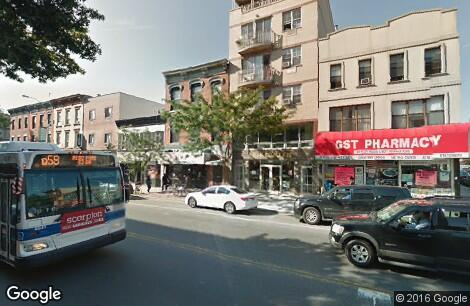

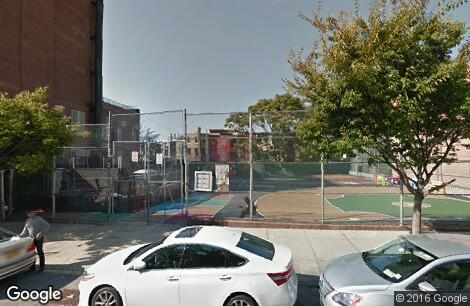

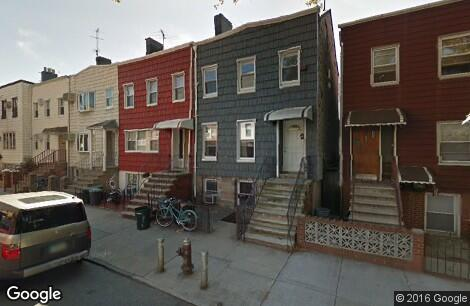

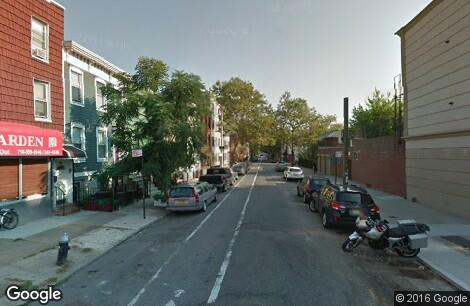

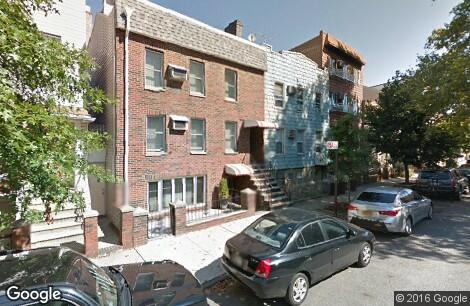

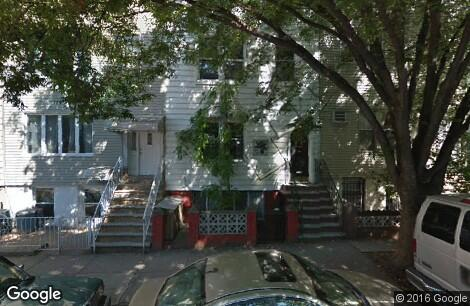

CPU times: user 161 ms, sys: 12.7 ms, total: 173 ms
Wall time: 2.47 s


In [183]:
%time run_app('667 grand st', 'brooklyn')